In [1]:
import tez
import pandas as pd
from sklearn import model_selection
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense
from tensorflow.keras.regularizers import l2



Chargement du dataset

In [2]:
r = pd.read_csv( 'ratings.csv' )
b = pd.read_csv( 'books.csv' )
b = b[['book_id', 'title', 'authors', 'original_publication_year']]

In [3]:
r.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
b.head()

,book_id,title,authors,original_publication_year
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,2008.0
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",1997.0
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,2005.0
3,4,To Kill a Mockingbird,Harper Lee,1960.0
4,5,The Great Gatsby,F. Scott Fitzgerald,1925.0


In [5]:
# Fusionner sur la colonne 'book_id'
df = pd.merge(r, b, on='book_id')

# Afficher les premières lignes après fusion
df.head()


,user_id,book_id,rating,title,authors,original_publication_year
0,1,258,5,The Shadow of the Wind (The Cemetery of Forgot...,"Carlos Ruiz Zafón, Lucia Graves",2001.0
1,2,4081,4,I am Charlotte Simmons,Tom Wolfe,2004.0
2,2,260,5,How to Win Friends and Influence People,Dale Carnegie,1936.0
3,2,9296,5,The Drama of the Gifted Child: The Search for ...,"Alice Miller, Ruth Ward",1979.0
4,2,2318,3,The Millionaire Next Door: The Surprising Secr...,"Thomas J. Stanley, William D. Danko",1995.0


In [6]:
#saving the merged dataset
df.to_csv('dataset_final.csv', index=False)

In [7]:
df.shape

(5976479, 6)

In [8]:
# 1. Vérifier les valeurs manquantes
print(df.isnull().sum())

user_id                         0
book_id                         0
rating                          0
title                           0
authors                         0
original_publication_year    5942
dtype: int64


In [9]:
# Remplacer les valeurs manquantes dans Publication_Year par une valeur par défaut
df['original_publication_year'] = df['original_publication_year'].fillna('Unknown')

In [10]:
# 2. Vérifier les doublons
print(df.duplicated().sum())

0


In [11]:
# 3. Vérifier les valeurs aberrantes dans la colonne 'rating'
print(df['rating'].describe())

count    5.976479e+06
mean     3.919866e+00
std      9.910868e-01
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [12]:
# Supprimer les valeurs de rating hors de la plage [0, 5]
df = df[(df['rating'] >= 0) & (df['rating'] <= 5)]


rating
4    2139018
5    1983093
3    1370916
2     359257
1     124195
Name: count, dtype: int64


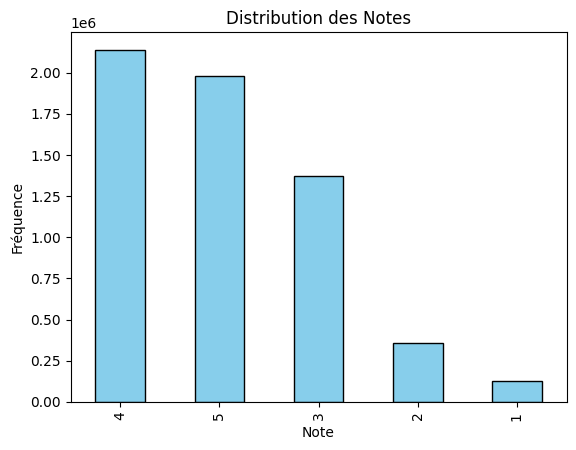

In [13]:

import matplotlib.pyplot as plt

# Afficher la fréquence des différentes notes
rating_counts = df['rating'].value_counts()

# Afficher les résultats
print(rating_counts)

# Visualiser la distribution des notes avec un graphique
rating_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution des Notes')
plt.xlabel('Note')
plt.ylabel('Fréquence')
plt.show()


depuis les résultats précédents on peut voir un déséquilibre entre les rating 5 et 4 par rapport au rest

In [14]:
# Vérifier le dataset nettoyé
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   user_id                    int64 
 1   book_id                    int64 
 2   rating                     int64 
 3   title                      object
 4   authors                    object
 5   original_publication_year  object
dtypes: int64(3), object(3)
memory usage: 273.6+ MB
None
   user_id  book_id  rating  \
0        1      258       5   
1        2     4081       4   
2        2      260       5   
3        2     9296       5   
4        2     2318       3   

                                               title  \
0  The Shadow of the Wind (The Cemetery of Forgot...   
1                             I am Charlotte Simmons   
2            How to Win Friends and Influence People   
3  The Drama of the Gifted Child: The Search for ...   
4  The Millionaire Next Door: The Surprising Secr...

In [15]:
#df_sampled = df.sample(frac=0.1, random_state=42)  # 10% des données juste pour essayer l entrainement sur une portion du dataset qui est grand et prend beaucoup de temps pour entrainer


In [29]:
import pandas as pd

# Suppose que ton DataFrame s'appelle df et que la colonne des ratings s'appelle 'rating'
df_sampled = pd.DataFrame()

# Définir le nombre d'échantillons à conserver pour chaque classe
samples_per_class = 124195  # Taille de la classe minoritaire
fraction = 0.05  # Prendre seulement 10% des données équilibrées
min_samples = int(samples_per_class * fraction)

# Échantillonner chaque classe
for rating in df['rating'].unique():
    # Filtrer les lignes correspondant au rating
    class_subset = df[df['rating'] == rating]
    # Échantillonner aléatoirement le nombre spécifié
    sampled_subset = class_subset.sample(n=min_samples, random_state=42)
    # Ajouter les échantillons au DataFrame équilibré
    df_sampled = pd.concat([df_sampled, sampled_subset])

# Mélanger les données pour éviter tout regroupement
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifier les répartitions
print(df_sampled['rating'].value_counts())

rating
2    6209
3    6209
4    6209
1    6209
5    6209
Name: count, dtype: int64


In [31]:
# Normaliser les ratings entre 0 et 1
df_sampled['rating_normalized'] = (df_sampled['rating'] - 1) / 4

In [49]:
df_sampled.to_csv('final.csv', index=False)


In [18]:

#rating_counts = df_sampled['rating'].value_counts()

# Vérifier que les clés dans `class_weights` couvrent toutes les valeurs de y_train
#class_weights = {rating: 1 / rating_counts.get(rating, 1) for rating in range(1, 6)}

# Vérifier les class_weights
#print(class_weights)


In [19]:
#définition d une fonction qui va pénaliser les ratings qui ne sont pas nombreux cela pour résoudre porbleme de desequilibrage de data
#def custom_loss(y_true, y_pred):
    # Supposons que les valeurs faibles de ratings soient moins fréquentes
    #weights = tf.cast(tf.greater(y_true, 3), tf.float32) * 2.0 + tf.cast(tf.less_equal(y_true, 3), tf.float32)
    #return tf.reduce_mean(tf.square(y_true - y_pred) * weights)


Splitting data

In [32]:


user_encoder = preprocessing.LabelEncoder()
book_encoder = preprocessing.LabelEncoder() 
# Encode user and movie IDs
df_sampled['user_id_encoded'] = user_encoder.fit_transform(df_sampled['user_id'])
df_sampled['book_id_encoded'] = book_encoder.fit_transform(df_sampled['book_id'])

# Séparer les caractéristiques (inputs) et les labels (output)
X = df_sampled[['user_id_encoded', 'book_id_encoded']]
y = df_sampled['rating_normalized']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y )


# Vérifier les shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24836, 2) (6209, 2) (24836,) (6209,)


Architecture du modele 

In [48]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.losses import Huber


# Définir les tailles uniques des utilisateurs et des livres
num_users = df_sampled['user_id_encoded'].nunique()
num_books = df_sampled['book_id_encoded'].nunique()


# Dimensions des embeddings
embedding_dim = 128



# Entrées
user_input = Input(shape=(1,), name='user_input')
book_input = Input(shape=(1,), name='book_input')



# Embeddings avec régularisation L2
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, 
                           name='user_embedding', embeddings_regularizer=l2(0.1))(user_input)
book_embedding = Embedding(input_dim=num_books, output_dim=embedding_dim, 
                            name='book_embedding', embeddings_regularizer=l2(0.1))(book_input)



# Aplatir les embeddings
user_flat = Flatten()(user_embedding)
book_flat = Flatten()(book_embedding)


# Combiner les embeddings
# Combiner les embeddings (utilisateur, livre, auteur)
concat = Concatenate()([user_flat, book_flat])

# Couches denses avec initialisation He et Dropout ajusté
dense_1 = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(concat)
dropout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(dropout_1)
dropout_2 = Dropout(0.2)(dense_2)
dense_3 = Dense(32, activation='relu', kernel_initializer='glorot_uniform')(dropout_2)

# Sortie
output = Dense(1)(dense_3)



# Définir le modèle
model = Model(inputs=[user_input, book_input], outputs=output)

# Compiler le modèle avec la perte pondérée
model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Pour un problème de régression continue
    metrics=['mae']  # Mean Absolute Error pour évaluer la performance
)




# Résumé du modèle
model.summary()

KeyError: 'user_id_encoded'

In [38]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


In [39]:
user_input_data = X_train['user_id_encoded'].values
book_input_data = X_train['book_id_encoded'].values


In [40]:
history = model.fit(
    [user_input_data, book_input_data], 
    y_train,
    epochs=10, 
    batch_size=64, 
    validation_data=([X_test['user_id_encoded'], X_test['book_id_encoded']], y_test)  
)


Epoch 1/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 45.4067 - mae: 0.3348 - val_loss: 0.1724 - val_mae: 0.3011
Epoch 2/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1717 - mae: 0.3037 - val_loss: 0.1768 - val_mae: 0.3022
Epoch 3/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1741 - mae: 0.3024 - val_loss: 0.1969 - val_mae: 0.2983
Epoch 4/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1955 - mae: 0.3008 - val_loss: 0.2070 - val_mae: 0.2995
Epoch 5/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.1999 - mae: 0.2982 - val_loss: 0.2034 - val_mae: 0.2990
Epoch 6/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.2109 - mae: 0.2984 - val_loss: 0.2134 - val_mae: 0.2950
Epoch 7/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.2201 - mae: 0.2988 - val_loss: 0.2028 - val_mae: 0.2982
Epoch 8/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.2020 - mae: 0.2974 - val_loss: 0.2011 - val_mae: 0.2967
Epoch 9/10
389/389 ━━━━━━━━━━━━━━━━━━━━ 7s 18m

In [45]:
# Sauvegarder le modèle
model.save('book_recommender_model.h5')

In [46]:
import pickle

# Sauvegarde des encoders
with open("user_encoder.pkl", "wb") as f:
    pickle.dump(user_encoder, f)

with open("book_encoder.pkl", "wb") as f:
    pickle.dump(book_encoder, f)



In [43]:
# Évaluer sur les données de test
results = model.evaluate(
    [X_test['user_id_encoded'], X_test['book_id_encoded']],
    y_test
)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1994 - mae: 0.2941
Test Loss: 0.19913412630558014, Test MAE: 0.2946695387363434


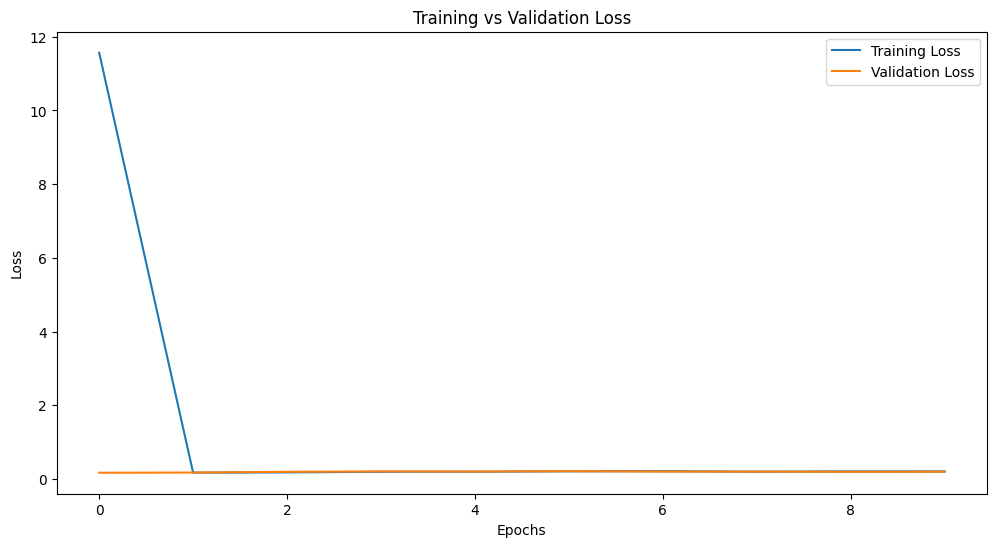

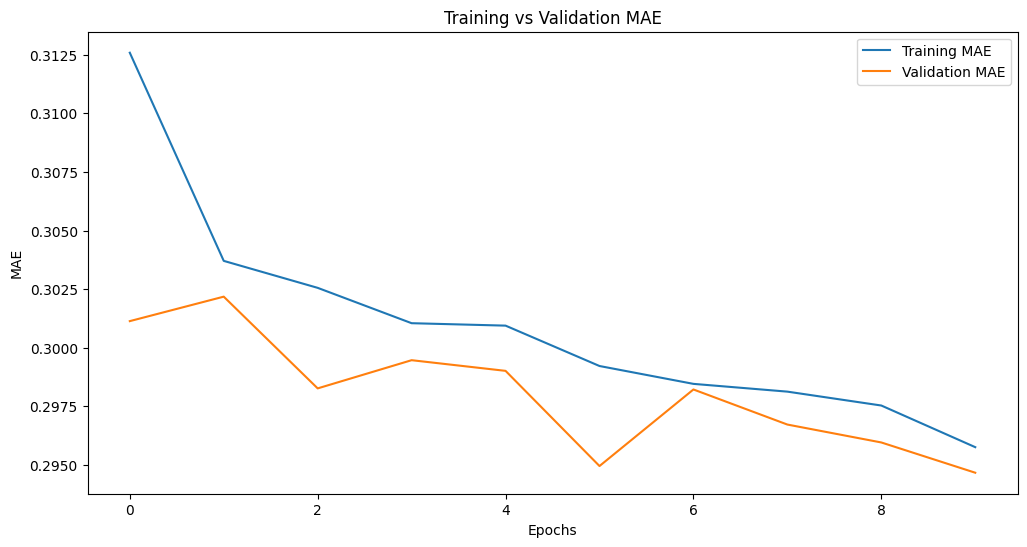

In [44]:
import matplotlib.pyplot as plt
#pour vérifier si il y  a un overfitting ou underfitting ou il performe bien 

# Visualiser la loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualiser MAE
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Visualiser RMSE
if 'root_mean_squared_error' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Training vs Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
